In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [22]:
hp = pd.read_csv('home_page_table.csv')
hp.head()


,user_id,page
0,313593,home_page
1,468315,home_page
2,264005,home_page
3,290784,home_page
4,639104,home_page


In [23]:
payment_confirmation = pd.read_csv('payment_confirmation_table.csv')
payment_confirmation.head()

,user_id,page
0,123100,payment_confirmation_page
1,704999,payment_confirmation_page
2,407188,payment_confirmation_page
3,538348,payment_confirmation_page
4,841681,payment_confirmation_page


In [24]:
payment_page = pd.read_csv('payment_page_table.csv')
payment_page.head()

,user_id,page
0,253019,payment_page
1,310478,payment_page
2,304081,payment_page
3,901286,payment_page
4,195052,payment_page


In [25]:
search =  pd.read_csv('search_page_table.csv')
search.head()

,user_id,page
0,15866,search_page
1,347058,search_page
2,577020,search_page
3,780347,search_page
4,383739,search_page


In [26]:
user =  pd.read_csv('user_table.csv')
user.head()

,user_id,date,device,sex
0,450007,2015-02-28,Desktop,Female
1,756838,2015-01-13,Desktop,Male
2,568983,2015-04-09,Desktop,Male
3,190794,2015-02-18,Desktop,Female
4,537909,2015-01-15,Desktop,Male


## Data Processing

In [34]:
data = pd.merge(left=user,right=hp, how='left',on='user_id')
data = pd.merge(left = data, right = search, how='left', on='user_id',suffixes=('_home','_search'))
data = pd.merge(left = data, right = payment_page, how='left', on='user_id')
data = pd.merge(left = data, right = payment_confirmation, how='left',on='user_id',suffixes=('_payment','_confirmation'))


In [35]:
data.head()

,user_id,date,device,sex,page_home,page_search,page_payment,page_confirmation
0,450007,2015-02-28,Desktop,Female,home_page,NaN,NaN,NaN
1,756838,2015-01-13,Desktop,Male,home_page,NaN,NaN,NaN
2,568983,2015-04-09,Desktop,Male,home_page,search_page,NaN,NaN
3,190794,2015-02-18,Desktop,Female,home_page,search_page,NaN,NaN
4,537909,2015-01-15,Desktop,Male,home_page,NaN,NaN,NaN


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90400 entries, 0 to 90399
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            90400 non-null  int64 
 1   date               90400 non-null  object
 2   device             90400 non-null  object
 3   sex                90400 non-null  object
 4   page_home          90400 non-null  object
 5   page_search        45200 non-null  object
 6   page_payment       6030 non-null   object
 7   page_confirmation  452 non-null    object
dtypes: int64(1), object(7)
memory usage: 6.2+ MB


## Analysis

### % of visitors for each page

In [54]:
conversion = 1 - pd.DataFrame(data.isnull().sum()) / len(data)

In [57]:
res = conversion.reset_index()[4:].rename(columns={0:'conversion','index':'page_type'})
res

,page_type,conversion
4,page_home,1.000000
5,page_search,0.500000
6,page_payment,0.066704
7,page_confirmation,0.005000


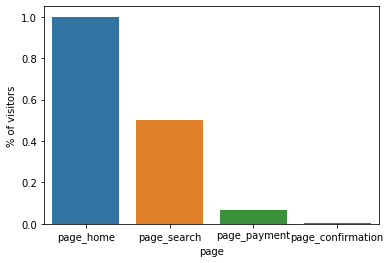

In [60]:
sns.barplot(x='page_type',y='conversion',data=res)
x = plt.xlabel('page')
y = plt.ylabel('% of visitors')

### Conversion Rate for each page

In [66]:
def conversion_rate(df):
    rates=[]
    ## Home page to search page
    tmp = df[~df['page_home'].isnull()]
    rates.append(1 - tmp['page_search'].isnull().sum() / len(tmp))
    ## Search page to payment page
    tmp = df[~df['page_search'].isnull()]
    rates.append(1 - tmp['page_payment'].isnull().sum() / len(tmp))
    ## Search page to payment confirmation
    tmp = df[~df['page_payment'].isnull()]
    rates.append(1 - tmp['page_confirmation'].isnull().sum() / len(tmp))
    
    return rates

### 1. Overall conversation rate

In [92]:
rates = conversion_rate(data)
maps = {'Page': ['home','search','payment'], 'Conversion Rate': rates}

In [93]:
overall_conv = pd.DataFrame(maps, columns=['Page','Conversion Rate'])
overall_conv

,Page,Conversion Rate
0,home,0.500000
1,search,0.133407
2,payment,0.074959


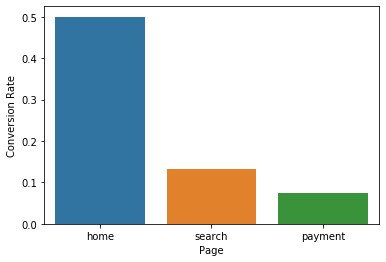

In [94]:
sns.barplot(x='Page',y='Conversion Rate',data=overall_conv)

### 2. Conversation rate by device

In [95]:
data.head()

,user_id,date,device,sex,page_home,page_search,page_payment,page_confirmation
0,450007,2015-02-28,Desktop,Female,home_page,NaN,NaN,NaN
1,756838,2015-01-13,Desktop,Male,home_page,NaN,NaN,NaN
2,568983,2015-04-09,Desktop,Male,home_page,search_page,NaN,NaN
3,190794,2015-02-18,Desktop,Female,home_page,search_page,NaN,NaN
4,537909,2015-01-15,Desktop,Male,home_page,NaN,NaN,NaN


In [96]:
data['device'].unique()

array(['Desktop', 'Mobile'], dtype=object)

In [100]:
desk_rates = conversion_rate(data[data['device'] == 'Desktop'])
mobile_rates = conversion_rate(data[data['device'] == 'Mobile'])

In [105]:
maps = {
    'Page': ['home', 'search', 'payment', 'home', 'search', 'payment'],
    'Device': ['Desktop', 'Desktop', 'Desktop', 'Mobile', 'Mobile', 'Mobile'],
    'Conversion Rate': desk_rates + mobile_rates
}

device_conv = pd.DataFrame(maps, columns=['Page','Device','Conversion Rate'])
device_conv

,Page,Device,Conversion Rate
0,home,Desktop,0.500000
1,search,Desktop,0.100000
2,payment,Desktop,0.049834
3,home,Mobile,0.500000
4,search,Mobile,0.200000
5,payment,Mobile,0.100000


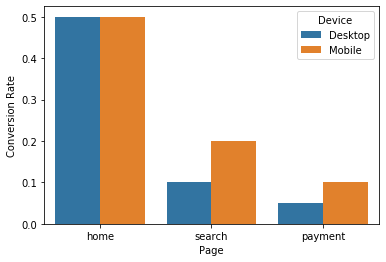

In [106]:
sns.barplot(x='Page',y='Conversion Rate',hue='Device',data=device_conv)

### 3. Conversation rate by Gender

In [108]:
male_rates = conversion_rate(data[data['sex'] == 'Male'])
female_rates = conversion_rate(data[data['sex'] == 'Female'])

In [110]:
maps = {
    'Page': ['home', 'search', 'payment', 'home', 'search', 'payment'],
    'Gender': ['Male', 'Male', 'Male', 'Female', 'Female', 'Female'],
    'Conversion Rate': male_rates + female_rates
}

device_conv = pd.DataFrame(maps, columns=['Page','Gender','Conversion Rate'])
device_conv

,Page,Gender,Conversion Rate
0,home,Male,0.496944
1,search,Male,0.130083
2,payment,Male,0.072014
3,home,Female,0.503073
4,search,Female,0.136708
5,payment,Female,0.077742


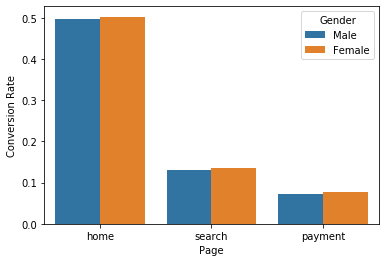

In [111]:
sns.barplot(x='Page',y='Conversion Rate',hue='Gender',data=device_conv)